# Retirement Planner

---

## Environment Setup

In [30]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [31]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [32]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [33]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [34]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [35]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change().dropna()
# Display sample data
daily_returns

,AGG,SPY
,close,close
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844
2019-01-09 00:00:00-05:00,0.000564,0.004130
...,...,...
2019-12-24 00:00:00-05:00,0.001292,0.000125
2019-12-26 00:00:00-05:00,0.000934,0.005136
2019-12-27 00:00:00-05:00,0.001245,-0.000155


In [36]:
# Compute daily volatility
daily_std = daily_returns.std()
daily_std

AGG  close    0.00209
SPY  close    0.00782
dtype: float64

In [37]:
# Save the last day's closing price
last_day_agg = df['AGG']['close'][-1]
last_day_spy = df['SPY']['close'][-1]
print(last_day_agg)
print(last_day_spy)

112.37
321.92


In [38]:
avg_daily_return = daily_returns.mean()
avg_daily_return

AGG  close    0.000213
SPY  close    0.001040
dtype: float64

In [39]:
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy

0.007820053413439366

In [40]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy

0.0010401250682146959

In [41]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
investments = ['AGG', 'SPY']
probability = [0.4, 0.6]

In [42]:
# Run the Monte Carlo Simulation
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for n in range(number_simulations):
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    for i in range(number_records):
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    portfolio_daily_returns = simulated_daily_returns.dot(probability)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001924,0.997505,0.995700,1.000706,1.005418,1.003570,1.005571,0.999817,1.001367,0.998857,...,1.001749,0.996287,1.004930,1.000495,0.998097,1.002517,0.997957,0.997281,1.001753,0.997614
2,1.006412,1.000685,0.996079,0.998850,1.007232,0.997944,1.001721,0.992298,1.000858,1.003897,...,1.003734,1.001279,1.007210,1.002169,0.999241,0.998879,0.997916,0.997456,1.001487,1.000715
3,1.005927,1.000743,0.998432,0.995538,1.006645,0.998968,1.004883,0.987721,1.000824,1.010424,...,1.004014,1.002155,1.010372,1.003881,0.994552,0.998615,1.001212,1.000150,1.004100,1.000767
4,1.012411,1.003035,0.997004,0.999986,1.008603,0.996444,1.004989,0.985180,1.006183,1.004915,...,1.004917,1.001713,1.009675,1.006305,0.998785,0.996726,0.997378,1.001179,1.006802,1.003199


In [43]:
# Check that the simulation ran successfully


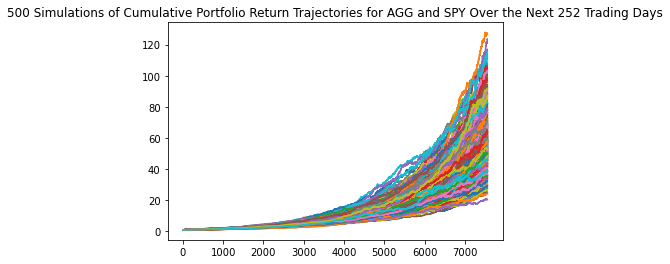

In [44]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories for AGG and SPY Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [45]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20 = portfolio_cumulative_returns.iloc[-20, :]
ending_cumulative_returns_20

0      63.489473
1      54.350849
2      65.382623
3      66.857820
4      66.954641
         ...    
495    93.090826
496    37.085980
497    69.230260
498    84.959419
499    38.563179
Name: 7541, Length: 500, dtype: float64

In [46]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_30 = portfolio_cumulative_returns.iloc[-30, :]
ending_cumulative_returns_30

0      63.519065
1      54.306995
2      65.260101
3      66.440011
4      66.779889
         ...    
495    93.167100
496    37.581269
497    70.088632
498    84.113296
499    38.270424
Name: 7531, Length: 500, dtype: float64

In [47]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns_20.quantile(q=[0.05, 0.95])
confidence_interval

0.05    34.406543
0.95    92.409604
Name: 7541, dtype: float64

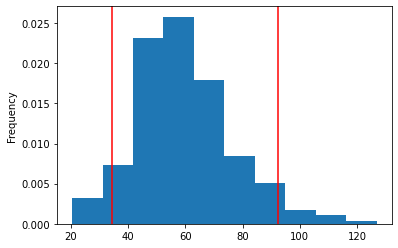

In [48]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns_20.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [49]:
# Compute cumulative returns
initial_investment = 20000
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,SPY prices,AGG prices
0,NaN,NaN
1,19948.602848,19954.744870
2,20058.014586,19985.147508
3,19998.136894,20026.639858
4,20119.746379,20026.585601


In [50]:
confidence_interval = cumulative_pnl.quantile(q=[0.10,.50, 0.90])
confidence_interval

,SPY prices,AGG prices
0.1,3.492672e+04,24179.031070
0.5,6.587267e+05,47578.902239
0.9,1.074827e+07,89370.457143


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [51]:
# Set initial investment
simulated_cumulative_returns_minus_inv = (1 + simulated_daily_returns).cumprod()
cumulative_pnl_minus_inv = initial_investment * simulated_cumulative_returns - 20000
cumulative_pnl_minus_inv.head()
# Compute expected portfolio return


,SPY prices,AGG prices
0,NaN,NaN
1,-51.397152,-45.255130
2,58.014586,-14.852492
3,-1.863106,26.639858
4,119.746379,26.585601


In [52]:
confidence_interval_minus_inv = cumulative_pnl_minus_inv.quantile(q=[0.10,.50, 0.90])
confidence_interval_minus_inv

,SPY prices,AGG prices
0.1,1.492672e+04,4179.031070
0.5,6.387267e+05,27578.902239
0.9,1.072827e+07,69370.457143


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [53]:
# Set Plaid's projected income
ten_percent = confidence_interval.iloc[:1]
withdraw_rate = ten_percent * .04

# Calculate the 4% withdrawal for the ending return as retirement income
total_value_minus_withdraw_10 = ten_percent - withdraw_rate
total_value_minus_withdraw_10
# Determine if the retirement income meets or exceeds the current projected income
    #both investments exceed the withdrawal rate. With the SPY invetment, the investor sees a return of $13,529 and with AGG 
    #they see a return of $3,211 with the withdrawal fee

,SPY prices,AGG prices
0.1,33529.654832,23211.869827


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [61]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
fifty_percent = confidence_interval.iloc[1:2]
withdraw_rate_50 = fifty_percent * .04
total_value_minus_withdraw_50 = fifty_percent - withdraw_rate_50
total_value_minus_withdraw_50

,SPY prices,AGG prices
0.5,632377.672096,45675.74615


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [65]:
# Compute projected returns
confidence_interval_monte = cumulative_pnl.quantile(q=[0.05,.50, 0.95])
# Display sample data
confidence_interval_monte

,SPY prices,AGG prices
0.05,2.635439e+04,22218.263926
0.50,6.587267e+05,47578.902239
0.95,1.178418e+07,93704.877065


In [76]:
# Plot the cumulative returns over time
prices_at_5 = confidence_interval_monte.iloc[:1]
prices_at_50 = confidence_interval_monte.iloc[1:2]
prices_at_95 = confidence_interval_monte.iloc[2:3]
avg_daily_return_spy =
std_dev_daily_return_spy = 

AttributeError: 'DataFrame' object has no attribute 'DataFrame'

In [57]:
# Compute portfolio performance over time

# Plot projected performance over time
